In [1]:
import pandas as pd
import numpy as np
from scipy.stats import bootstrap
import matplotlib
import os
from collections import defaultdict
from sklearn.feature_selection import SelectKBest, chi2, f_classif

import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import metrics
import warnings 
from numpy import mean
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
warnings.filterwarnings("ignore")

# Download AReM data

In [2]:
data = pd.read_csv("../data/AReM/bending1/dataset1.csv",skiprows=4)
data

,# Columns: time,avg_rss12,var_rss12,avg_rss13,var_rss13,avg_rss23,var_rss23
0,0,39.25,0.43,22.75,0.43,33.75,1.3
1,250,39.25,0.43,23.00,0.00,33.00,0.0
2,500,39.25,0.43,23.25,0.43,33.00,0.0
3,750,39.50,0.50,23.00,0.71,33.00,0.0
4,1000,39.50,0.50,24.00,0.00,33.00,0.0
...,...,...,...,...,...,...,...
475,118750,43.33,0.47,25.00,0.00,30.00,0.0
476,119000,43.50,0.50,25.50,0.50,30.00,0.0
477,119250,43.50,0.50,24.75,0.43,30.00,0.0
478,119500,43.50,0.50,24.33,0.47,30.00,0.0


In [3]:
folder = '../data/AReM/'
sub_folders = [name for name in os.listdir(folder) if os.path.isdir(os.path.join(folder, name))]
series = ["avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "vg_rss23", "ar_rss23"]
train_keys = []
test_keys = []
d = defaultdict()
for activity in sub_folders:
    test_count=2 if activity=="bending1" or activity=="bending2" else 3
    datasets = [name for name in os.listdir(folder+activity+"/")]
    for data in datasets:
        if data == "dataset1.csv" or data == "dataset2.csv" or (test_count==3 and data == "dataset3.csv"):
            test_keys.append((activity,data))
        else:
            train_keys.append((activity,data))
        d[(activity,data)] = pd.read_csv('../data/AReM/'+activity+"/"+data,usecols=[0,1,2,3,4,5,6],sep=r',|\s+|;',engine="python",skiprows=5,on_bad_lines='skip',header=None)
        d[(activity,data)].columns =["Time", "avg_rss12", "var_rss12", "avg_rss13", "var_rss13", "vg_rss23", "ar_rss23"]

# Test and Train data

In [4]:
train_X = []
train_Y = []
test_X = []
test_Y = []
for i in train_keys:
    train_X.append(d[i])
    train_Y.append(pd.DataFrame([i[0]]*len(d[i])))
for i in test_keys:
    test_X.append(d[i])
    test_Y.append(pd.DataFrame([i[0]]*len(d[i])))
train_X = pd.concat(train_X)
train_Y = pd.concat(train_Y)
test_X = pd.concat(test_X)
test_Y = pd.concat(test_Y)
print("Train X shape: ",str(train_X.shape))
print("Train Y shape: ",str(train_Y.shape))
print("Test X shape: ",str(test_X.shape))
print("Test Y shape: ",str(test_Y.shape))

Train X shape:  (33119, 7)
Train Y shape:  (33119, 1)
Test X shape:  (9120, 7)
Test Y shape:  (9120, 1)


### Time Domain Features used for time-series Classification are:
- Some **common time-domain features** are:
    - Standard Deviation
    - Means
    - Skewness
    - Normalized Maximums
    - Normalized Minimums
- **Wiens J.** in his paper uses the following time domain features for his experiments on Patient risk stratification for hospital-associated c. diff as a time-series classification task:
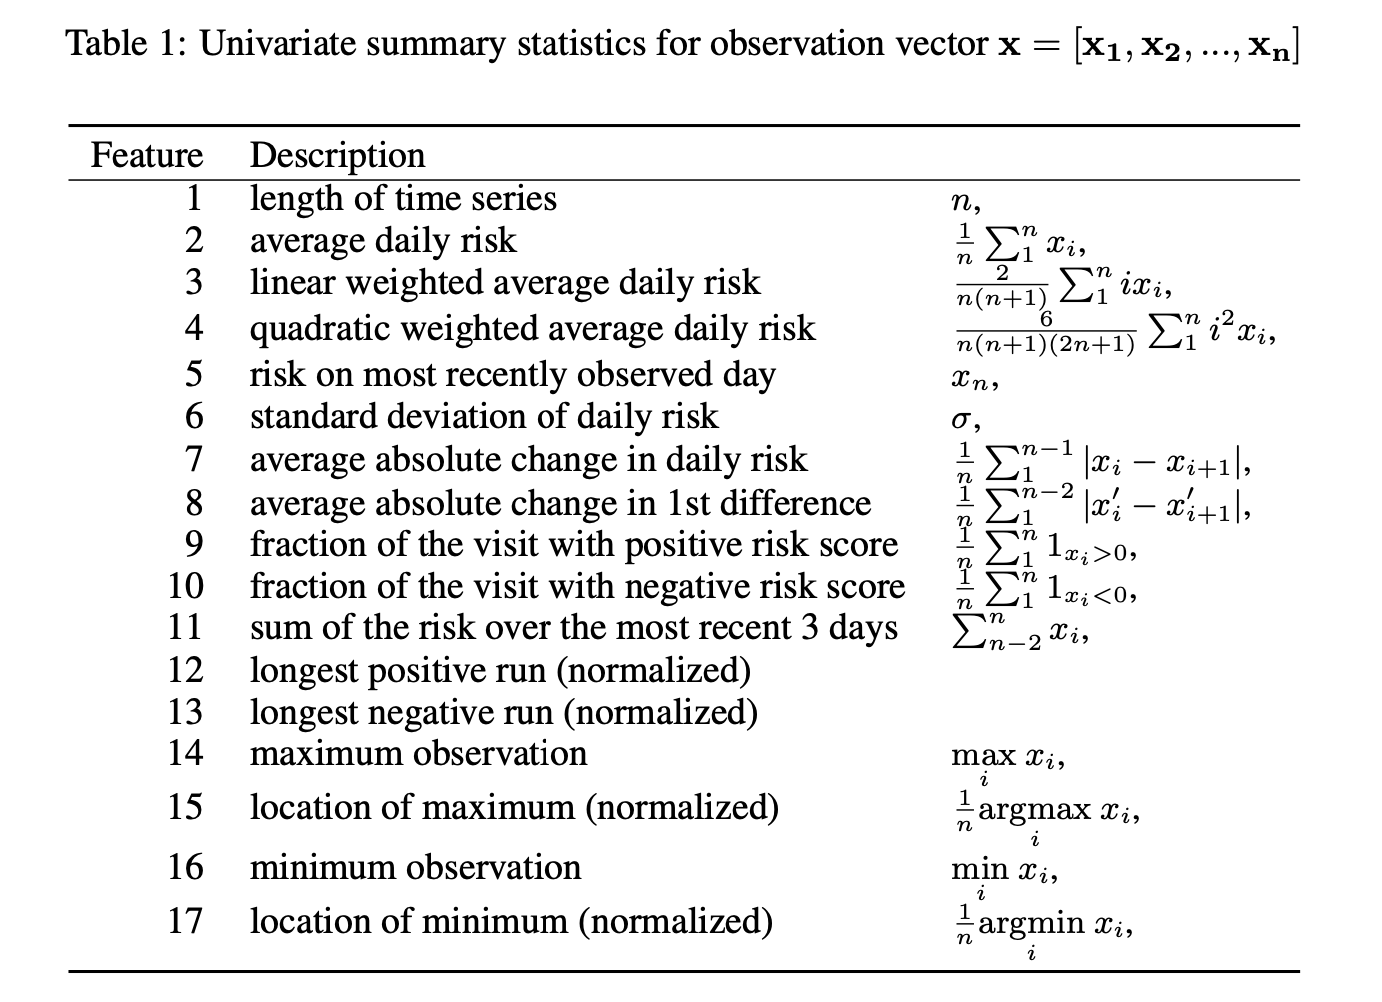


- Additionally, there exists feature extraction libraries in python which provide with numerous features options:
    - tsfel -> https://tsfel.readthedocs.io/en/latest/descriptions/feature_list.html
    - tsfresh -> This library helps find out the important features of the time-series automatically without having to perform data engineering manually. https://tsfresh.readthedocs.io/en/latest/
- Furthermore, **H. Liu** in his paper performs experiments for pattern recognition of human motion where instead of finding out the time-domain features manually they utilised a **Deep sparse auto encoder** to perform the Low dimension feature extraction on the time-series.

### References
- [1] Liu, H., & Taniguchi, T. (2014, September). Feature extraction and pattern recognition for human motion by a deep sparse autoencoder. In 2014 IEEE International Conference on Computer and Information Technology (pp. 173-181). IEEE.
- [2] Wiens, J., Horvitz, E., & Guttag, J. (2012). Patient risk stratification for hospital-associated c. diff as a time-series classification task. Advances in Neural Information Processing Systems, 25.

In [5]:
columns = ["Instances","Activity","Dataset"]
for i in range(1,7):
    columns.append("min"+str(i))
    columns.append("max"+str(i))
    columns.append("mean"+str(i))
    columns.append("median"+str(i))
    columns.append("standard deviation"+str(i))
    columns.append("first quartile"+str(i))
    columns.append("third quartile"+str(i))

features = pd.DataFrame(columns=columns)

for activity in sub_folders:
    datasets = [name for name in os.listdir(folder+activity+"/")]
    for data in datasets:
        temp=[len(features.index)+1,activity,data]
        for i in range(len(series)):
            elem = series[i]
            count,mean,sd,mini,q1,median,q3,maxi = d[(activity,data)][elem].describe()
            temp+=[mini,maxi,mean,median,sd,q1,q3]
        features.loc[len(features.index)] = temp
features

,Instances,Activity,Dataset,min1,max1,mean1,median1,standard deviation1,first quartile1,third quartile1,...,standard deviation5,first quartile5,third quartile5,min6,max6,mean6,median6,standard deviation6,first quartile6,third quartile6
0,1,bending1,dataset7.csv,36.25,48.00,43.969125,44.50,1.618364,43.3100,44.67,...,3.318301,20.5000,23.7500,0.0,2.96,0.555313,0.490,0.487826,0.0000,0.8300
1,2,bending1,dataset6.csv,37.00,48.00,43.454958,43.25,1.386098,42.5000,45.00,...,2.488862,22.2500,24.0000,0.0,5.26,0.679646,0.500,0.622534,0.4300,0.8700
2,3,bending1,dataset4.csv,33.00,47.75,42.179813,43.50,3.670666,39.1500,45.00,...,3.849448,30.4575,36.3300,0.0,2.18,0.613521,0.500,0.524317,0.0000,1.0000
3,4,bending1,dataset5.csv,33.00,45.75,41.678063,41.75,2.243490,41.3300,42.75,...,2.411026,28.4575,31.2500,0.0,1.79,0.383292,0.430,0.389164,0.0000,0.5000
4,5,bending1,dataset1.csv,37.25,45.00,40.624792,40.50,1.476967,39.2500,42.00,...,2.188449,33.0000,36.0000,0.0,1.92,0.570583,0.430,0.582915,0.0000,1.3000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,84,cycling,dataset12.csv,18.50,44.25,35.752354,36.00,4.614802,33.0000,39.33,...,3.120057,14.0000,18.0625,0.0,9.39,3.069667,2.770,1.748326,1.7975,4.0600
84,85,cycling,dataset15.csv,24.25,45.00,37.177042,36.25,3.581301,34.5000,40.25,...,2.890347,17.9500,21.7500,0.0,9.34,2.921729,2.500,1.852600,1.5000,3.9000
85,86,cycling,dataset14.csv,23.33,43.50,36.244083,36.75,3.822016,33.4575,39.25,...,3.617702,15.7500,21.0000,0.0,11.15,3.530500,3.110,1.963685,2.1700,4.6175
86,87,cycling,dataset8.csv,26.25,44.25,36.957458,36.29,3.434863,34.5000,40.25,...,2.851673,14.0000,18.2500,0.0,8.34,2.934625,2.525,1.631380,1.6600,4.0300


## Standard Deviation of each feature

In [6]:
std_features = features[features.columns[3:]].std()
std_features

min1                   9.569975
max1                   4.394362
mean1                  5.335718
median1                5.440054
standard deviation1    1.772153
first quartile1        6.153590
third quartile1        5.138925
min2                   0.000000
max2                   5.062729
mean2                  1.574164
median2                1.412244
standard deviation2    0.884105
first quartile2        0.946386
third quartile2        2.125266
min3                   2.956462
max3                   4.875137
mean3                  4.008380
median3                4.036396
standard deviation3    0.946710
first quartile3        4.220658
third quartile3        4.171628
min4                   0.000000
max4                   2.183625
mean4                  1.166114
median4                1.145586
standard deviation4    0.458242
first quartile4        0.843620
third quartile4        1.552504
min5                   6.124001
max5                   5.741238
mean5                  5.675593
median5 

## 90% Confidence Level for each Feature

In [7]:
confidence_level = pd.DataFrame(columns=["Feature","90% Confidence Level"])
for col in features.columns[3:]:
    data = features[col]
    data = (data,)
    res = bootstrap(data, np.std, axis=-1, confidence_level=0.9,n_resamples=1000, random_state=np.random.default_rng(),method='percentile')
    ci_l, ci_u = res.confidence_interval
    confidence_level.loc[len(confidence_level.index)] = [col,"["+str(round(ci_l, 3))+" , "+str(round(ci_u, 3))+"]"]
confidence_level.index+=1
confidence_level

,Feature,90% Confidence Level
1,min1,"[8.235 , 10.755]"
2,max1,"[3.284 , 5.254]"
3,mean1,"[4.668 , 5.861]"
4,median1,"[4.784 , 5.964]"
5,standard deviation1,"[1.572 , 1.928]"
6,first quartile1,"[5.573 , 6.588]"
7,third quartile1,"[4.307 , 5.831]"
8,min2,"[0.0 , 0.0]"
9,max2,"[4.62 , 5.393]"
10,mean2,"[1.405 , 1.698]"


## For this question I will be using SelectkBest of sklearn to choose the best three time-domain features 

#### Using SelectKBest with Chi-Squared as score function 

In [8]:
selectK = SelectKBest(chi2, k=3)
x = features[features.columns[3:]]
x.fillna(0)
y = features[features.columns[1]]
X_new = selectK.fit_transform(x, y)

In [9]:
chi = pd.DataFrame(selectK.scores_).fillna(0).values
chi = np.reshape(chi,len(chi))
values_overall = {"mini":0,"maxi":0,"mean":0,"median":0,"sd":0,"Q1":0,"Q3":0}
for i in range(0,len(chi),7):
    values_overall["mini"]+=chi[i]
    values_overall["maxi"]+=chi[i+1]
    values_overall["mean"]+=chi[i+2]
    values_overall["median"]+=chi[i+3]
    values_overall["sd"]+=chi[i+4]
    values_overall["Q1"]+=chi[i+5]
    values_overall["Q3"]+=chi[i+6]
print(values_overall)

{'mini': 834.7275792063118, 'maxi': 577.290772997615, 'mean': 542.9600610307092, 'median': 532.2400690658203, 'sd': 164.66617309784843, 'Q1': 557.7547670468094, 'Q3': 600.9194228521303}


 - Order of feature relevance based on **Chi-squared stats** is:<br>
min > Q3 > max > Q1 > mean > median > sd


In [10]:
selectK = SelectKBest(f_classif, k=3)
x = features[features.columns[3:]]
x.fillna(0)
y = features[features.columns[1]]
X_new = selectK.fit_transform(x, y)

In [11]:
f_val = pd.DataFrame(selectK.scores_).fillna(0).values
f_val = np.reshape(f_val,len(f_val))
f_values_overall = {"mini":0,"maxi":0,"mean":0,"median":0,"sd":0,"Q1":0,"Q3":0}
for i in range(0,len(f_val),7):
    f_values_overall["mini"]+=f_val[i]
    f_values_overall["maxi"]+=f_val[i+1]
    f_values_overall["mean"]+=f_val[i+2]
    f_values_overall["median"]+=f_val[i+3]
    f_values_overall["sd"]+=f_val[i+4]
    f_values_overall["Q1"]+=f_val[i+5]
    f_values_overall["Q3"]+=f_val[i+6]
print(f_values_overall)

{'mini': 82.4385385298241, 'maxi': 255.4206521516738, 'mean': 2686.088489003285, 'median': 2413.8322496415135, 'sd': 857.1228703794958, 'Q1': 1203.9461548695767, 'Q3': 2488.428451710228}


- Order of feature relevance based on **ANOVA stats** is:<br>
mean > Q3 > median > Q1 > sd > max > min

## Inference
Based on the above two orders of feature relevance and on their respective scores we observe the following:
- **Q3(third quartile)** has **high values while using both f_classif(ANOVA) and chi2 (Chi-squared)**. Thus, we will include it in the top three feratures.
- We observe that max, mean and median have almost similar values while using Chi-Squared(approx. 550) but while using ANOVA, the values of mean and median are extremely high (above 2000) as compared to max and min (below 260). Thus, we will choose the other two features to be **mean and median.**
- **Thus, my final three most important time-domain features are:**
    - **Third Quartile**
    - **Mean**
    - **Median**

In [12]:
import seaborn as sns

# Binary Classification Using Logistic Regression

### Binary class (0 = Bending) and (1 = Other Classification)

In [13]:
mapping = {"bending1": 0, "bending2": 0, "cycling": 1, "lying": 1,"sitting":1,"standing":1,"walking":1}

In [14]:
ids= [idx for idx, x in enumerate(list(zip(features['Activity'],features['Dataset']))) if x not in train_keys]
train_binary = features.drop(labels=ids, axis=0)[['Activity','mean1', 'mean2','mean6','median1','median2','median6','third quartile1','third quartile2','third quartile6']]
train_binary["Activity"] = pd.DataFrame(train_binary["Activity"].map(mapping).fillna(train_binary["Activity"]))

In [15]:
train_binary

,Activity,mean1,mean2,mean6,median1,median2,median6,third quartile1,third quartile2,third quartile6
0,0,43.969125,0.413125,0.555313,44.50,0.47,0.490,44.67,0.5000,0.8300
1,0,43.454958,0.378083,0.679646,43.25,0.47,0.500,45.00,0.5000,0.8700
2,0,42.179813,0.696042,0.613521,43.50,0.50,0.500,45.00,1.1200,1.0000
3,0,41.678063,0.535979,0.383292,41.75,0.50,0.430,42.75,0.7100,0.5000
6,0,43.954500,0.426250,0.493292,44.33,0.47,0.430,45.00,0.5000,0.9400
...,...,...,...,...,...,...,...,...,...,...
83,1,35.752354,3.328104,3.069667,36.00,2.83,2.770,39.33,4.3300,4.0600
84,1,37.177042,2.374208,2.921729,36.25,1.92,2.500,40.25,3.1300,3.9000
85,1,36.244083,2.736021,3.530500,36.75,2.17,3.110,39.25,3.7400,4.6175
86,1,36.957458,2.420083,2.934625,36.29,2.05,2.525,40.25,3.3500,4.0300


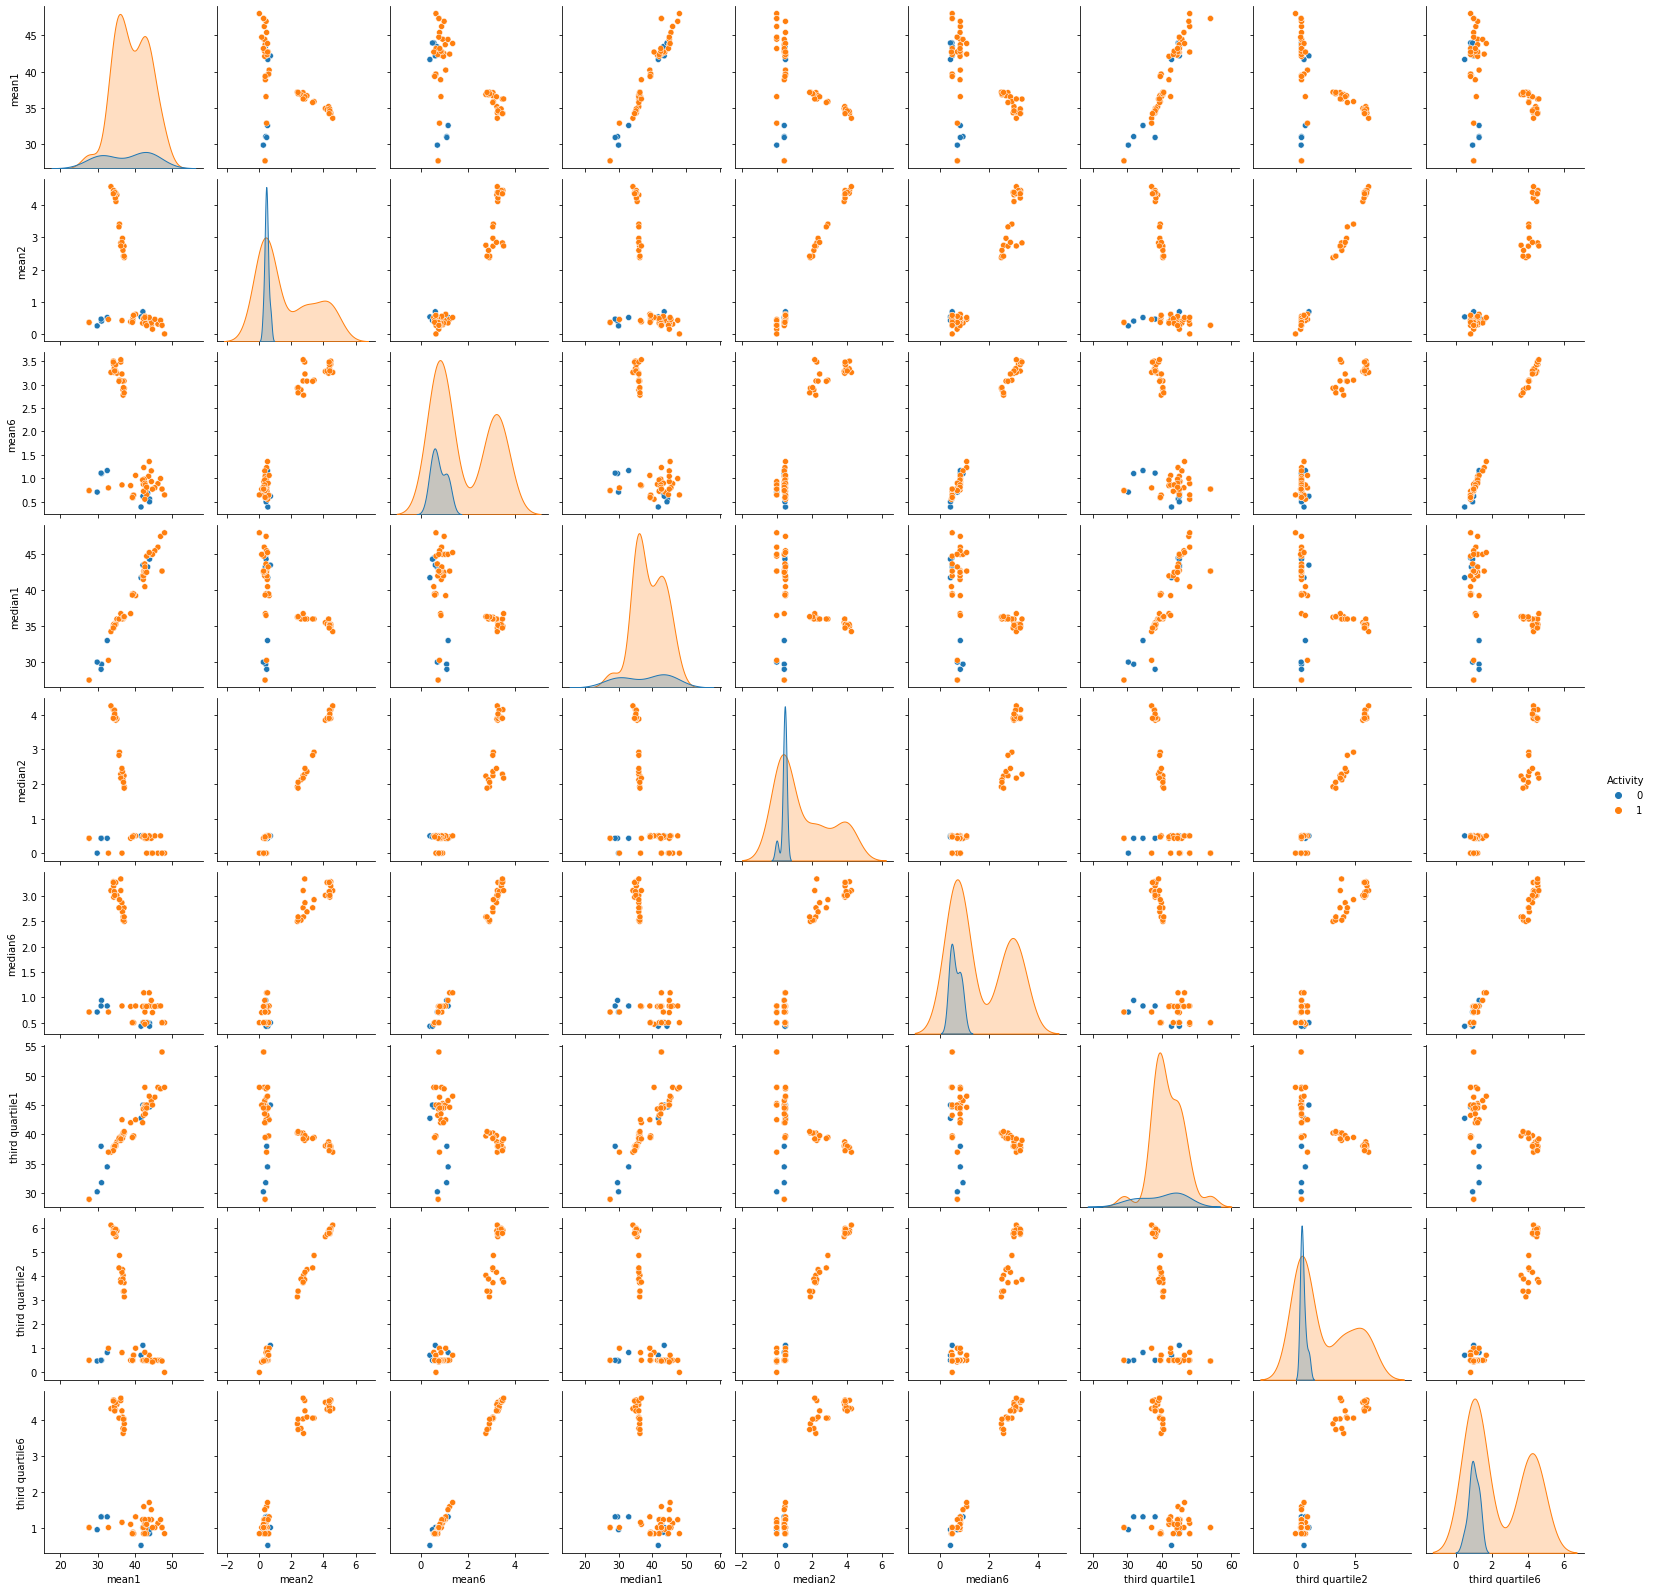

In [16]:
ax = sns.pairplot(train_binary,hue="Activity")

In [17]:
def divide(l,df,batch_no):
    start = (len(df)//l)*batch_no
    end = (start + (len(df)//l))%(len(df)+1)
#     print(start,end)
    df_batch = df[start:end]
    return df_batch

def create_features(col_no,folder,series,l):
    columns = ["Instances","Activity","Dataset"]
    for i in col_no:
        for j in range(l):
            columns.append("mean"+str(i)+"_"+str(j+1)+"l"+str(l))
            columns.append("median"+str(i)+"_"+str(j+1)+"l"+str(l))
            columns.append("third quartile"+str(i)+"_"+str(j+1)+"l"+str(l))
    features_new = pd.DataFrame(columns=columns)            
    for activity in sub_folders:
        datasets = [name for name in os.listdir(folder+activity+"/")]
        for data in datasets:
            temp=[len(features.index)+1,activity,data]
            for batch_no in range(l):
                for elem in series:
                    df = divide(l,d[(activity,data)][elem],batch_no)
                    _,mean,_,_,_,median,q3,_ = df.describe()
                    temp+=[mean,median,q3]
            features_new.loc[len(features_new.index)] = temp
    return features_new

def getTrainTestSplit_from_featuresNew(features_new,mask="type1"):
    if mask=="type1":
        mapping = {"bending1": 0, "bending2": 0, "cycling": 1, "lying": 1,"sitting":1,"standing":1,"walking":1}
    else:
        mapping = {"bending1": 0, "bending2": 0, "cycling": 1, "lying": 2,"sitting":3,"standing":4,"walking":5}
        
    ids= [idx for idx, x in enumerate(list(zip(features_new['Activity'],features_new['Dataset']))) if x not in train_keys]
    train_binary = features_new.drop(labels=ids, axis=0)
    train_binary["Activity"] = pd.DataFrame(train_binary["Activity"].map(mapping).fillna(train_binary["Activity"]))
    train_binary = train_binary.drop(columns=["Instances","Dataset"])
    
    ids= [idx for idx, x in enumerate(list(zip(features_new['Activity'],features_new['Dataset']))) if x not in test_keys]
    test_binary = features_new.drop(labels=ids, axis=0)
    test_binary["Activity"] = pd.DataFrame(test_binary["Activity"].map(mapping).fillna(test_binary["Activity"]))
    test_binary = test_binary.drop(columns=["Instances","Dataset"])
    
    return train_binary,test_binary

In [18]:
features_new = create_features([1,2,6],folder,[series[0],series[1],series[5]],2)
features_new

,Instances,Activity,Dataset,mean1_1l2,median1_1l2,third quartile1_1l2,mean1_2l2,median1_2l2,third quartile1_2l2,mean2_1l2,...,third quartile2_1l2,mean2_2l2,median2_2l2,third quartile2_2l2,mean6_1l2,median6_1l2,third quartile6_1l2,mean6_2l2,median6_2l2,third quartile6_2l2
0,89,bending1,dataset7.csv,43.486208,43.71,44.50,0.378667,0.470,0.50,0.524875,...,0.8300,44.452042,44.500,44.7500,0.447583,0.500,0.5000,0.585750,0.50,0.8300
1,89,bending1,dataset6.csv,44.117042,45.00,45.00,0.250042,0.000,0.50,0.815417,...,1.1200,42.792875,42.670,43.0000,0.506125,0.500,0.5000,0.543875,0.50,0.7100
2,89,bending1,dataset4.csv,43.278875,45.00,45.25,0.673292,0.485,1.00,0.640958,...,1.2200,41.080750,42.000,44.5000,0.718792,0.500,1.2275,0.586083,0.47,0.8700
3,89,bending1,dataset5.csv,41.621208,42.33,44.25,0.623083,0.500,0.83,0.419083,...,0.7100,41.734917,41.500,42.0000,0.448875,0.500,0.5000,0.347500,0.43,0.5000
4,89,bending1,dataset1.csv,40.946958,41.25,42.00,0.375667,0.470,0.50,0.589000,...,1.3000,40.302625,39.415,42.0000,0.341542,0.430,0.5000,0.552167,0.43,0.9400
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,89,cycling,dataset12.csv,35.692167,35.50,39.25,3.324208,2.865,4.44,3.172417,...,4.3500,35.812542,36.000,39.3725,3.332000,2.830,4.2750,2.966917,2.59,3.7400
84,89,cycling,dataset15.csv,36.954208,36.00,40.25,2.392667,1.920,3.27,3.005375,...,3.9375,37.399875,36.500,40.2500,2.355750,1.920,3.0075,2.838083,2.45,3.8325
85,89,cycling,dataset14.csv,36.342750,36.75,39.00,2.691917,2.170,3.77,3.547750,...,4.7025,36.145417,36.500,39.2700,2.780125,2.170,3.6850,3.513250,3.08,4.5000
86,89,cycling,dataset8.csv,36.865417,36.25,40.00,2.387250,2.085,3.35,2.964792,...,4.0375,37.049500,36.415,40.2500,2.452917,1.905,3.3775,2.904458,2.57,3.7700


In [19]:
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 
train_binary

,Activity,mean1_1l2,median1_1l2,third quartile1_1l2,mean1_2l2,median1_2l2,third quartile1_2l2,mean2_1l2,median2_1l2,third quartile2_1l2,mean2_2l2,median2_2l2,third quartile2_2l2,mean6_1l2,median6_1l2,third quartile6_1l2,mean6_2l2,median6_2l2,third quartile6_2l2
0,0,43.486208,43.71,44.50,0.378667,0.470,0.50,0.524875,0.470,0.8300,44.452042,44.500,44.7500,0.447583,0.500,0.5000,0.585750,0.50,0.8300
1,0,44.117042,45.00,45.00,0.250042,0.000,0.50,0.815417,0.710,1.1200,42.792875,42.670,43.0000,0.506125,0.500,0.5000,0.543875,0.50,0.7100
2,0,43.278875,45.00,45.25,0.673292,0.485,1.00,0.640958,0.765,1.2200,41.080750,42.000,44.5000,0.718792,0.500,1.2275,0.586083,0.47,0.8700
3,0,41.621208,42.33,44.25,0.623083,0.500,0.83,0.419083,0.430,0.7100,41.734917,41.500,42.0000,0.448875,0.500,0.5000,0.347500,0.43,0.5000
6,0,44.057167,44.50,45.00,0.381042,0.470,0.50,0.598250,0.500,1.0000,43.851833,43.500,45.0000,0.471458,0.500,0.5000,0.388333,0.00,0.7100
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
83,1,35.692167,35.50,39.25,3.324208,2.865,4.44,3.172417,2.900,4.3500,35.812542,36.000,39.3725,3.332000,2.830,4.2750,2.966917,2.59,3.7400
84,1,36.954208,36.00,40.25,2.392667,1.920,3.27,3.005375,2.650,3.9375,37.399875,36.500,40.2500,2.355750,1.920,3.0075,2.838083,2.45,3.8325
85,1,36.342750,36.75,39.00,2.691917,2.170,3.77,3.547750,3.200,4.7025,36.145417,36.500,39.2700,2.780125,2.170,3.6850,3.513250,3.08,4.5000
86,1,36.865417,36.25,40.00,2.387250,2.085,3.35,2.964792,2.500,4.0375,37.049500,36.415,40.2500,2.452917,1.905,3.3775,2.904458,2.57,3.7700


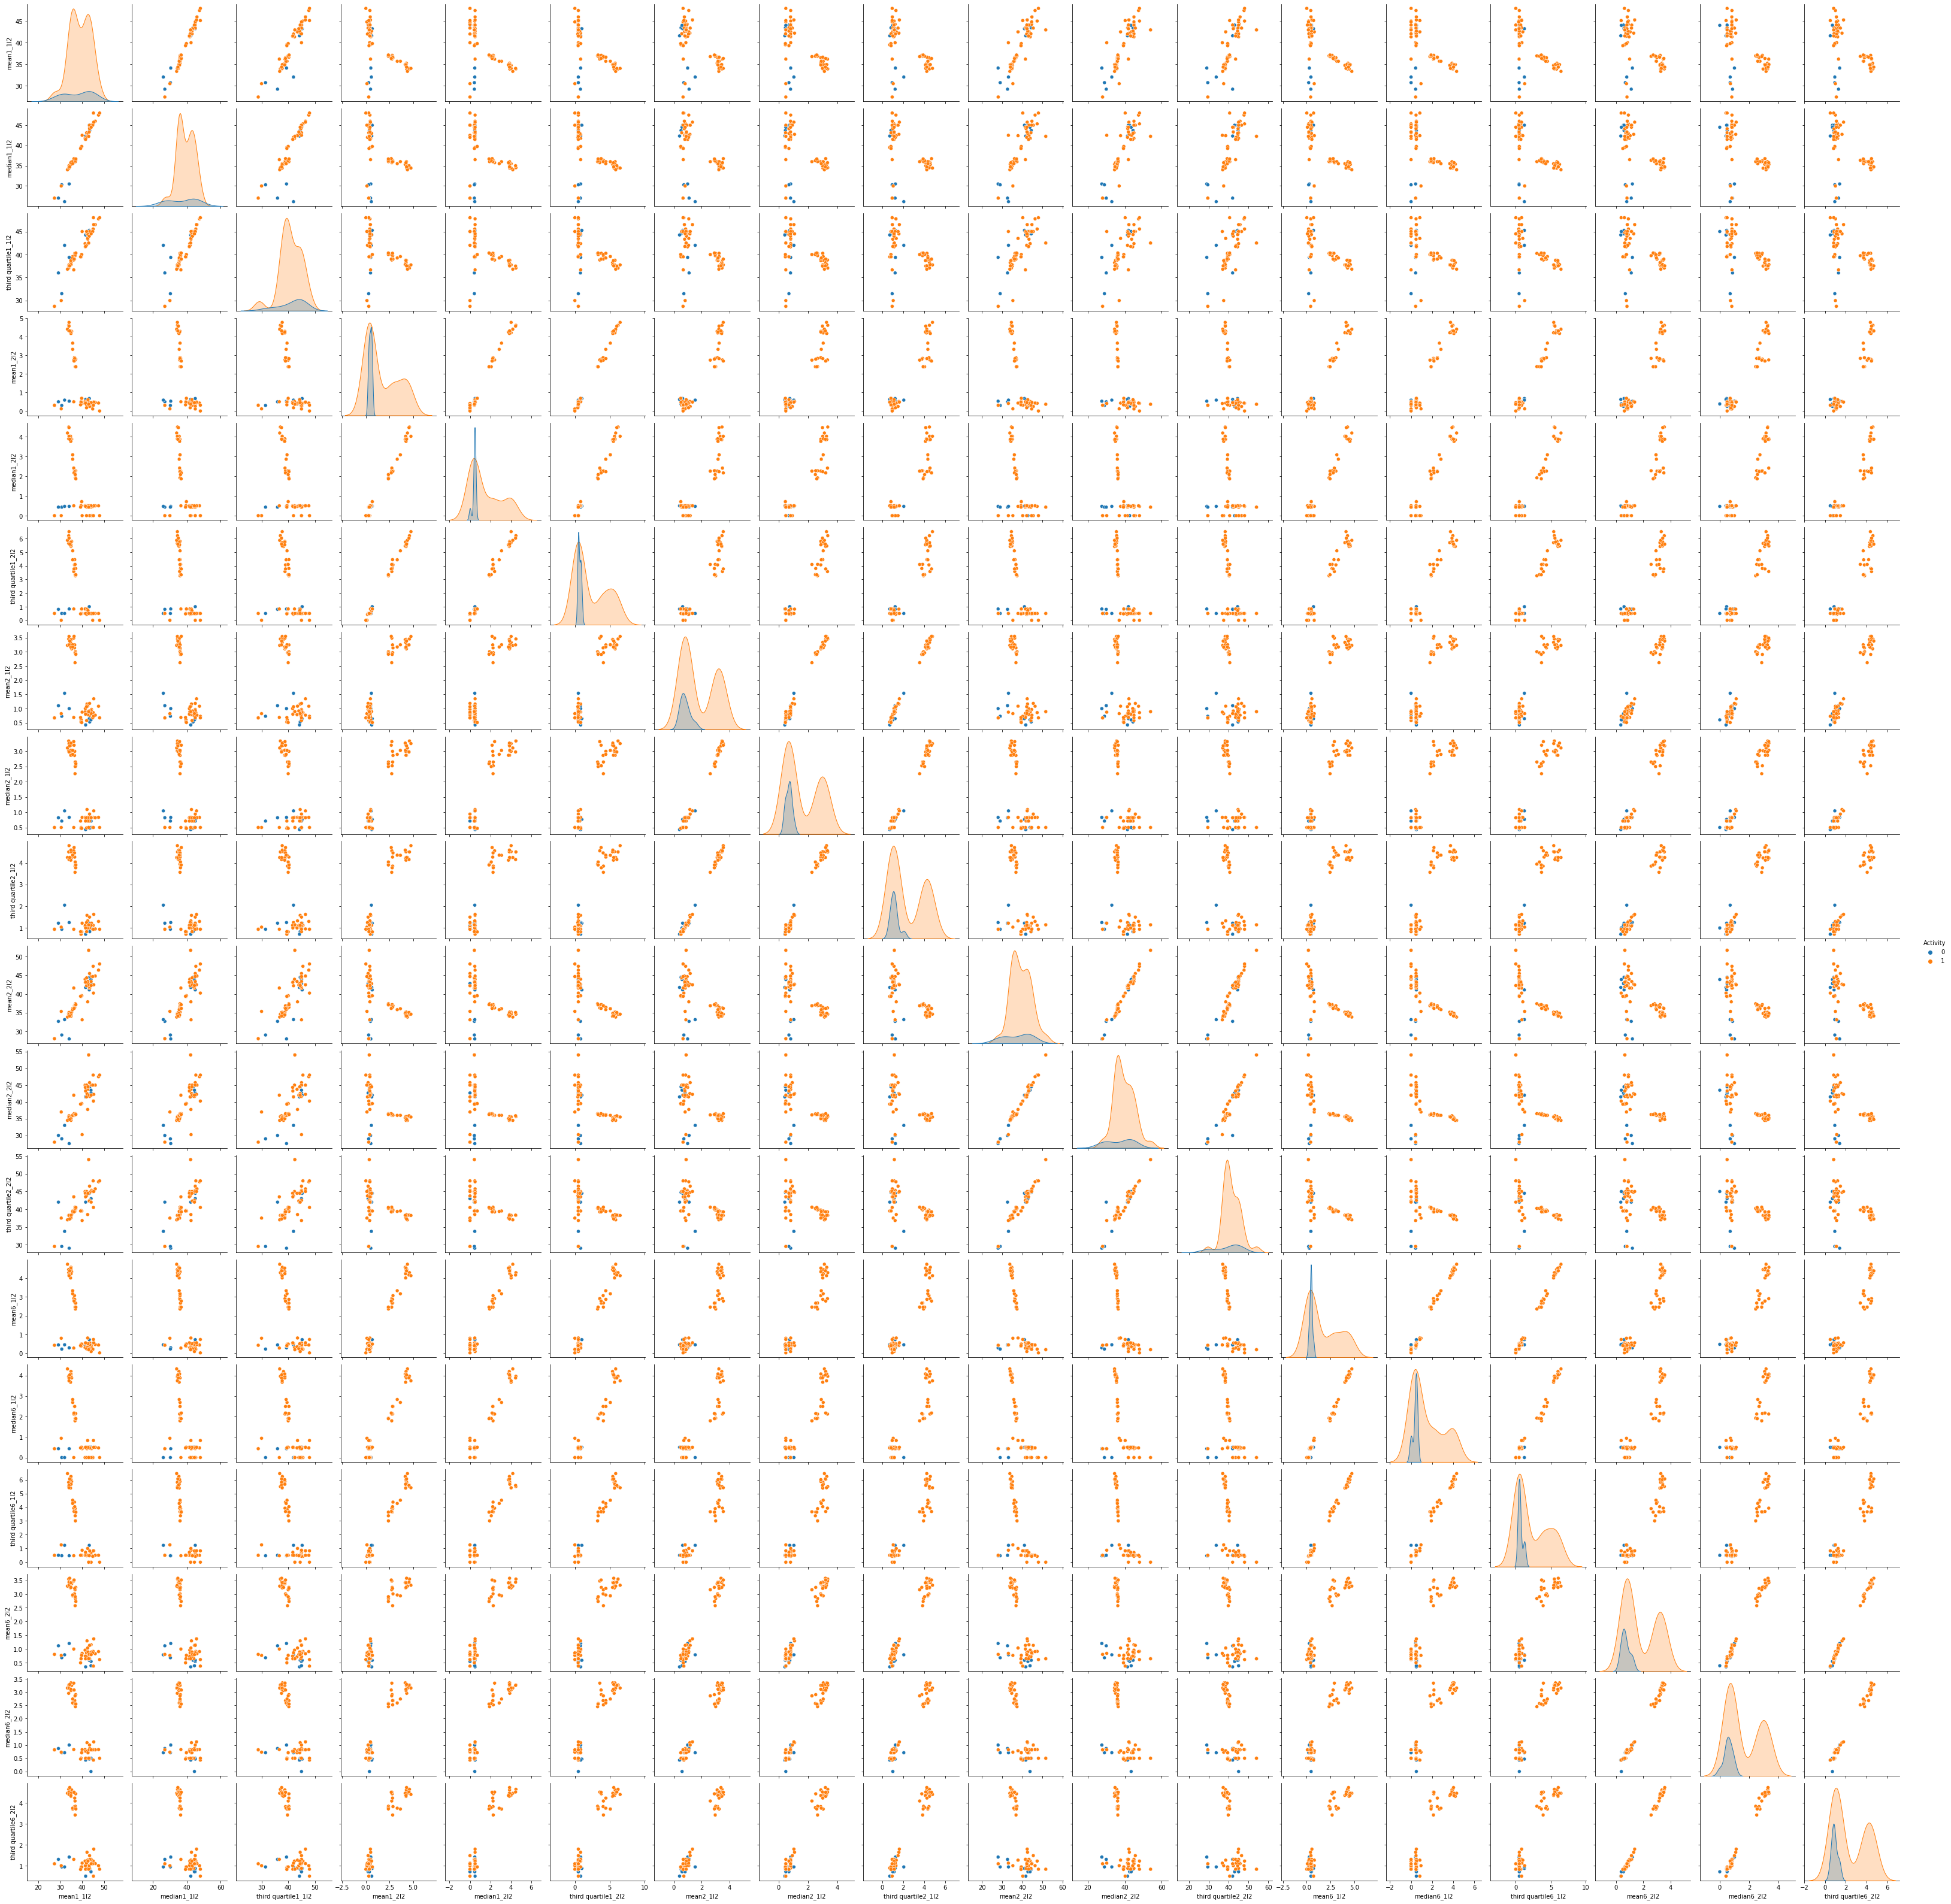

In [20]:
ax = sns.pairplot(train_binary,hue="Activity")

### Inference 
Yes, there is significant difference in the two scatter plots. The data points seem to be well separated in the second scatter plot. Also we observe linearity between the selected features for the second half of the series 6 training dataset.

In [21]:
import statsmodels.api as sm
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import StratifiedKFold
from sklearn.feature_selection import RFECV
from sklearn import metrics
import warnings 
from numpy import mean
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")

**The correct way to do cross-validation is to do use it while performing feature elimination. Feature selection is a part of training and must be done with cross validation. The wrong way to do Cross validation is to first select the features and then perform Cross validation**

Finding the best value of l,p below:

In [22]:
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 
    
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    model = LogisticRegression(penalty="none")
    rfecv = RFECV(
        estimator=model,
        step=1,
        cv=StratifiedKFold(5,shuffle = True,random_state=42),
        scoring="accuracy",
    )
    rfecv.fit(x1, y1)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Val_Acuracy: %f"%max(rfecv.cv_results_["mean_test_score"]))
    if max_val_acc<max(rfecv.cv_results_["mean_test_score"]):
        max_val_acc=max(rfecv.cv_results_["mean_test_score"])
        max_l = k
        max_p = rfecv.n_features_
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l,max_p)

L value: 1
Optimal number of features : 3
Val_Acuracy: 0.971429

L value: 2
Optimal number of features : 24
Val_Acuracy: 0.957143

L value: 3
Optimal number of features : 4
Val_Acuracy: 0.985714

L value: 4
Optimal number of features : 5
Val_Acuracy: 0.985714

L value: 5
Optimal number of features : 3
Val_Acuracy: 0.985714

L value: 6
Optimal number of features : 7
Val_Acuracy: 1.000000

L value: 7
Optimal number of features : 2
Val_Acuracy: 1.000000

L value: 8
Optimal number of features : 30
Val_Acuracy: 0.985714

L value: 9
Optimal number of features : 29
Val_Acuracy: 0.985714

L value: 10
Optimal number of features : 45
Val_Acuracy: 0.971429

L value: 11
Optimal number of features : 62
Val_Acuracy: 0.985714

L value: 12
Optimal number of features : 6
Val_Acuracy: 0.985714

L value: 13
Optimal number of features : 3
Val_Acuracy: 0.985714

L value: 14
Optimal number of features : 129
Val_Acuracy: 0.985714

L value: 15
Optimal number of features : 81
Val_Acuracy: 0.985714

L value: 16

**The best values are l=6 and p=7 with validation accuracy as 100%**<br>
Re-fitting the model below for the above best values:

In [23]:
k = max_l

print("Best L value: "+str(k))

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]
model = LogisticRegression(penalty="none")
rfecv = RFECV(
    estimator=model,
#         step=1,
    cv=StratifiedKFold(5,shuffle = True,random_state=42),
    scoring="accuracy",
)
rfecv.fit(x1, y1)
prediction = rfecv.predict(x1)
print("Optimal number of features : %d" % rfecv.n_features_)
print("Cross Val_Acuracy: %f" % max(rfecv.cv_results_["mean_test_score"]))
c_matrix = metrics.confusion_matrix(y1, prediction)
print("Confusion Matrix")
print(c_matrix)
print("Extreacted features are :"+str(rfecv.get_feature_names_out()))

print()
x2 = x1[rfecv.get_feature_names_out()]
x2 = sm.add_constant(x2)
model = sm.Logit(y1, x2).fit(method="lbfgs",maxiter=30)
print_model = model.summary()
print(print_model)
print()

Best L value: 6
Optimal number of features : 7
Cross Val_Acuracy: 1.000000
Confusion Matrix
[[ 9  0]
 [ 0 60]]
Extreacted features are :['mean1_5l6' 'third quartile1_5l6' 'mean2_5l6' 'third quartile4_1l6'
 'third quartile5_1l6' 'third quartile6_3l6' 'mean6_5l6']

RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            8     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  6.93147D-01    |proj g|=  1.54310D+01

At iterate    1    f=  5.59335D-01    |proj g|=  4.12804D+00

At iterate    2    f=  4.48690D-01    |proj g|=  2.90011D+00

At iterate    3    f=  3.65268D-01    |proj g|=  1.30413D+00

At iterate    4    f=  3.42554D-01    |proj g|=  2.33507D+00

At iterate    5    f=  2.88749D-01    |proj g|=  3.52216D+00

At iterate    6    f=  1.83062D-01    |proj g|=  3.10470D+00

At iterate    7    f=  1.11681D-01    |proj g|=  1.25646D+00

At iterate    8    f=  7.09765D-02    |proj g|=  4.71517D-01

At iterate

 This problem is unconstrained.


**The coefficients and the p-values calculated above by fitting the logistic regresison using statsmodel are:**<br>
- const                   = 0.0463<br>
- mean1_5l6              = -1.5601<br>
- third quartile1_5l6    = -1.6621<br>
- mean2_5l6              = -1.3935<br>
- third quartile4_1l6    = 1.2414<br>
- third quartile5_1l6    = 1.3149<br>
- third quartile6_3l6    = 1.2270<br>
- mean6_5l6              = -1.2013<br>
<br>

**p value for all the coefficients is 1. Further we also note that this is because of the complete seperation of data points.**

As Calculated above the **confusion matrix** for train set came out to be:<br>
[[9 0]<br>
 [0 60]]

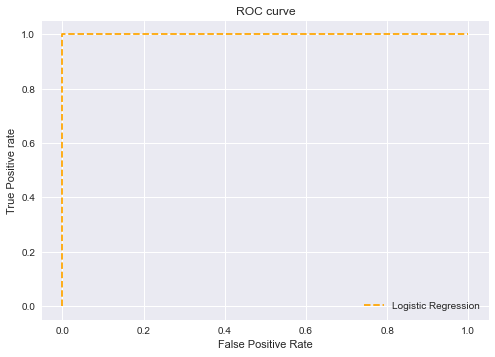

AUC = 1.000000


In [24]:
prediction_prob = rfecv.predict_proba(x1)
fpr, tpr, thresh = metrics.roc_curve(y1, prediction_prob[:,1], pos_label=1)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

auc_score = metrics.roc_auc_score(y1, prediction_prob[:,1])
print("AUC = %f" % auc_score)

# Accuracy comparison test set for l=6 and p=7

In [25]:
k = max_l

x1 = test_binary.loc[:, test_binary.columns!='Activity']
y1 = test_binary["Activity"]

prediction = rfecv.predict(x1)
print("Optimal number of features : %d" % rfecv.n_features_)
print("Accuracy: %f" % metrics.accuracy_score(y1, prediction))
c_matrix = metrics.confusion_matrix(y1, prediction)
print("Confusion Matrix:")
print(c_matrix)
print("Extreacted features are :"+str(rfecv.get_feature_names_out()))

Optimal number of features : 7
Accuracy: 1.000000
Confusion Matrix:
[[ 4  0]
 [ 0 15]]
Extreacted features are :['mean1_5l6' 'third quartile1_5l6' 'mean2_5l6' 'third quartile4_1l6'
 'third quartile5_1l6' 'third quartile6_3l6' 'mean6_5l6']


**We observe that the test accuracy is similar to the cross-validation accuracy(100%).**

Yes, there is instability in calculating logistic regression parameters.<br>
As seen in the error thrown by the statsmodel api we observe that **there is complete seperation** which causes all the feature coefficients to be instable (might go to infinity too) and become insignificant.

# Using SMOTE for removing class imbalance

In [ ]:
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 
    
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    
    oversample = SMOTE()
    x1, y1 = oversample.fit_resample(x1, y1)
    
    
    model = LogisticRegression(penalty="none")
    rfecv = RFECV(
        estimator=model,
        step=1,
        cv=StratifiedKFold(5,shuffle = True,random_state=42),
        scoring="accuracy",
    )
    rfecv.fit(x1, y1)
    print("Optimal number of features : %d" % rfecv.n_features_)
    print("Cross Val_Acuracy: %f"%max(rfecv.cv_results_["mean_test_score"]))
    if max_val_acc<max(rfecv.cv_results_["mean_test_score"]):
        max_val_acc=max(rfecv.cv_results_["mean_test_score"])
        max_l = k
        max_p = rfecv.n_features_
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l,max_p)

L value: 1
Optimal number of features : 12
Cross Val_Acuracy: 0.991667

L value: 2
Optimal number of features : 10
Cross Val_Acuracy: 0.975000

L value: 3
Optimal number of features : 3
Cross Val_Acuracy: 0.991667

L value: 4
Optimal number of features : 2
Cross Val_Acuracy: 0.991667

L value: 5
Optimal number of features : 4
Cross Val_Acuracy: 1.000000

L value: 6
Optimal number of features : 6
Cross Val_Acuracy: 1.000000

L value: 7
Optimal number of features : 2
Cross Val_Acuracy: 0.991667

L value: 8
Optimal number of features : 3
Cross Val_Acuracy: 0.991667

L value: 9
Optimal number of features : 3
Cross Val_Acuracy: 1.000000

L value: 10
Optimal number of features : 8
Cross Val_Acuracy: 1.000000

L value: 11
Optimal number of features : 4
Cross Val_Acuracy: 1.000000

L value: 12
Optimal number of features : 3
Cross Val_Acuracy: 0.991667

L value: 13
Optimal number of features : 2
Cross Val_Acuracy: 0.991667

L value: 14
Optimal number of features : 3
Cross Val_Acuracy: 0.991667


**The best value of (l,p) are l=5 and p=4**<br>
Refitting the model below for the best values on **Train Set**:

In [27]:
k = max_l

print("Best L value: "+str(k))

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]

oversample = SMOTE()
x1, y1 = oversample.fit_resample(x1, y1)    

model = LogisticRegression()
rfecv = RFECV(
    estimator=model,
#         step=1,
    cv=StratifiedKFold(5,shuffle = True,random_state=42),
    scoring="accuracy",
)
rfecv.fit(x1, y1)
prediction = rfecv.predict(x1)
print("Optimal number of features : %d" % rfecv.n_features_)
print("Cross Val_Acuracy: %f" % max(rfecv.cv_results_["mean_test_score"]))
print("Extracted features are :"+str(rfecv.get_feature_names_out()))
c_matrix = metrics.confusion_matrix(y1, prediction)
print(c_matrix)

print()
# x2 = x1[rfecv.get_feature_names_out()]
# x2 = sm.add_constant(x2)
# model = sm.Logit(y1, x2).fit(method="lbfgs")
# print_model = model.summary()
# print(print_model)
# print()

Best L value: 5
Optimal number of features : 4
Cross Val_Acuracy: 1.000000
Extracted features are :['mean1_5l5' 'third quartile1_5l5' 'third quartile3_3l5' 'mean6_4l5']
[[60  0]
 [ 0 60]]



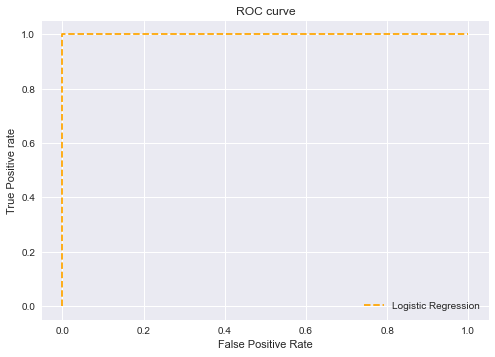

AUC = 1.000000


In [28]:
prediction_prob = rfecv.predict_proba(x1)
fpr, tpr, thresh = metrics.roc_curve(y1, prediction_prob[:,1], pos_label=1)

plt.style.use('seaborn')

# plot roc curves
plt.plot(fpr, tpr, linestyle='--',color='orange', label='Logistic Regression')
# title
plt.title('ROC curve')
# x label
plt.xlabel('False Positive Rate')
# y label
plt.ylabel('True Positive rate')

plt.legend(loc='best')
plt.savefig('ROC',dpi=300)
plt.show();

auc_score = metrics.roc_auc_score(y1, prediction_prob[:,1])
print("AUC = %f" % auc_score)

**The best value of (l,p) are l=5 and p=4**<br>
Refitting the model below for the best values on **Test Set**:

# Binary Classification Using L1-penalized logistic regression

**Repeat 2(a)iii using L1-penalized logistic regression,8 i.e. instead of using p- values for variable selection, use L1 regularization. Note that in this problem, you have to cross-validate for both l, the number of time series into which you break each of your instances, and λ, the weight of L1 penalty in your logistic regression objective function (or C, the budget). Packages usually perform cross-validation for λ automatically.9**

- In this part we will use LogisticRegressionCV with CrossValidation = 5 (default = stratifiedKFold), penatly = l1 and solver=liblinear
- To check the number of features selected using L1 penalised we simply check the number of non-zero coefficients after fitting a model for a particular l.

In [29]:
# # from sklearn.linear_model import LogisticRegressionCV
from sklearn.linear_model import LogisticRegressionCV
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
    
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    model = LogisticRegressionCV(cv=5, penalty= "l1",solver="liblinear",random_state=17)
    model.fit(x1,y1)
#     print(model.densify())
    print("Val_Acuracy: %f"%model.score(x1,y1))
#     print(model.coef_)
    print("Optimal Number of features: %d"%np.count_nonzero(model.coef_))
    if max_val_acc<model.score(x1,y1):
        max_val_acc= model.score(x1,y1)
        max_l = k
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l)

L value: 1
Val_Acuracy: 0.985507
Optimal Number of features: 4

L value: 2
Val_Acuracy: 0.985507
Optimal Number of features: 6

L value: 3
Val_Acuracy: 1.000000
Optimal Number of features: 8

L value: 4
Val_Acuracy: 1.000000
Optimal Number of features: 7

L value: 5
Val_Acuracy: 1.000000
Optimal Number of features: 6

L value: 6
Val_Acuracy: 1.000000
Optimal Number of features: 8

L value: 7
Val_Acuracy: 1.000000
Optimal Number of features: 7

L value: 8
Val_Acuracy: 1.000000
Optimal Number of features: 8

L value: 9
Val_Acuracy: 1.000000
Optimal Number of features: 8

L value: 10
Val_Acuracy: 0.971014
Optimal Number of features: 4

L value: 11
Val_Acuracy: 1.000000
Optimal Number of features: 8

L value: 12
Val_Acuracy: 1.000000
Optimal Number of features: 12

L value: 13
Val_Acuracy: 1.000000
Optimal Number of features: 9

L value: 14
Val_Acuracy: 1.000000
Optimal Number of features: 9

L value: 15
Val_Acuracy: 1.000000
Optimal Number of features: 16

L value: 16
Val_Acuracy: 1.00000

**The best value of (l,p) are (3,8)**<br>
Re-fitting the LogisticRegressionCV for the above values:

In [30]:
k=max_l

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new) 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]

model = LogisticRegressionCV(cv=5, penalty= "l1",solver="liblinear",random_state=17)
model.fit(x1,y1)

print("Train Acuracy: %f"%model.score(x1,y1))

xTest = test_binary.loc[:, test_binary.columns!='Activity']
yTest = test_binary["Activity"]


print("Test Acuracy: %f"%model.score(xTest,yTest))

Train Acuracy: 1.000000
Test Acuracy: 1.000000


- Both L1-penlaised and p-value selection **perform equally in terms of Accuracy giving 100% on both test and train.**
- **L1-penalized Logistic regression is better to implement** than the p-value selection which is actually a backward selection algorithm for feature selection. The p-value selection takes more time and is computationally exhaustive as it removes the features stepwise where as LASSO (l1 penalty) converts the non-significant coefficients to absolute zero through regularization.

# Multi Class Classification

**Find the best l in the same way as you found it in 2(b)i to build an L1- penalized multinomial regression model to classify all activities in your train- ing set.10 Report your test error. Research how confusion matrices and ROC curves are defined for multiclass classification and show them for this problem if possible.**

In [31]:
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
    
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 
#     print(train_binary.shape)
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    model = LogisticRegressionCV(cv=5, penalty= "l1",solver="liblinear",random_state=17)
    model.fit(x1,y1)

    print("Accuracy: %f"%model.score(x1,y1))
#     print(model.coef_)
    print("Optimal Number of features: %d"%np.count_nonzero(model.coef_))
    if max_val_acc<model.score(x1,y1):
        max_val_acc= model.score(x1,y1)
        max_l = k
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l)

L value: 1
Accuracy: 0.985507
Optimal Number of features: 67

L value: 2
Accuracy: 1.000000
Optimal Number of features: 72

L value: 3
Accuracy: 1.000000
Optimal Number of features: 99

L value: 4
Accuracy: 1.000000
Optimal Number of features: 86

L value: 5
Accuracy: 1.000000
Optimal Number of features: 186

L value: 6
Accuracy: 1.000000
Optimal Number of features: 334

L value: 7
Accuracy: 1.000000
Optimal Number of features: 293

L value: 8
Accuracy: 1.000000
Optimal Number of features: 162

L value: 9
Accuracy: 1.000000
Optimal Number of features: 189

L value: 10
Accuracy: 1.000000
Optimal Number of features: 259

L value: 11
Accuracy: 1.000000
Optimal Number of features: 295

L value: 12
Accuracy: 1.000000
Optimal Number of features: 427

L value: 13
Accuracy: 1.000000
Optimal Number of features: 429

L value: 14
Accuracy: 1.000000
Optimal Number of features: 409

L value: 15
Accuracy: 1.000000
Optimal Number of features: 317

L value: 16
Accuracy: 1.000000
Optimal Number of feat

**The best value of l is 2**<br>
Re-fitting the model below with the best value of l and calculating the train and test errors

Best L value: 2
Train Acuracy: 1.000000
Confusion Matrix on Train Dataset:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


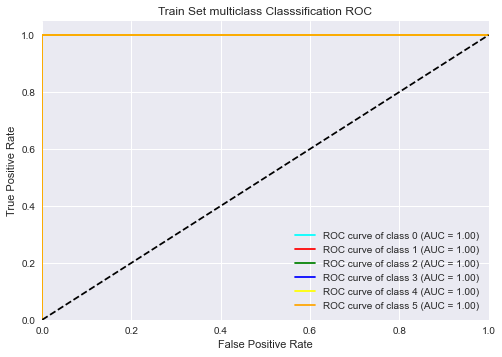


Test Acuracy: 0.736842
Test Error: 0.263158
Confusion Matrix on Test Dataset:
[[3 0 0 1 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [1 0 0 1 1 0]
 [0 0 1 1 1 0]
 [0 0 0 0 0 3]]


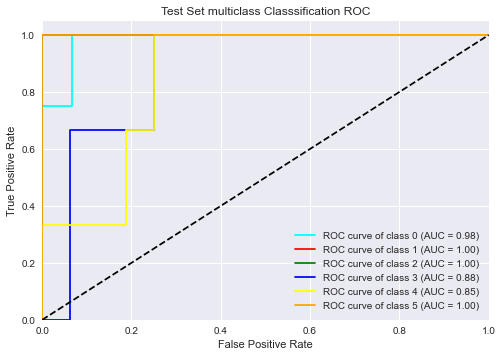

In [32]:
k=max_l

print("Best L value: "+str(k))

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]

model = LogisticRegressionCV(cv=5, penalty= "l1",solver="liblinear",random_state=17)
model.fit(x1,y1)
prediction = model.predict(x1)
c_matrix = metrics.confusion_matrix(y1, prediction)
print("Train Acuracy: %f"%model.score(x1,y1))
print("Confusion Matrix on Train Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(y1)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(x1)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train Set multiclass Classsification ROC")
plt.legend(loc="lower right")
plt.show()


print()
xTest = test_binary.loc[:, test_binary.columns!='Activity']
yTest = test_binary["Activity"]

prediction = model.predict(xTest)
c_matrix = metrics.confusion_matrix(yTest, prediction)
print("Test Acuracy: %f"%model.score(xTest,yTest))
print("Test Error: %f"%(1-model.score(xTest,yTest)))
print("Confusion Matrix on Test Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(yTest)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(xTest)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set multiclass Classsification ROC")
plt.legend(loc="lower right")
plt.show()

**The Test Error for multinomial classification with L1 penalised and liblinear as solver is 0.26** (liblinear as solver makes the multi_class in sklearn as ovr)<br>
This could be made better by using the saga as solver which sets the multi_class as multinomial in sklearn

In [33]:
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
    
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 
#     print(train_binary.shape)
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    model = LogisticRegressionCV(cv=5, penalty= "l1",solver="saga",random_state=17)
    model.fit(x1,y1)

    print("Accuracy: %f"%model.score(x1,y1))
#     print(model.coef_)
    print("Optimal Number of features: %d"%np.count_nonzero(model.coef_))
    if max_val_acc<model.score(x1,y1):
        max_val_acc= model.score(x1,y1)
        max_l = k
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l)

L value: 1
Accuracy: 0.927536
Optimal Number of features: 108

L value: 2
Accuracy: 0.971014
Optimal Number of features: 216

L value: 3
Accuracy: 0.956522
Optimal Number of features: 319

L value: 4
Accuracy: 0.942029
Optimal Number of features: 269

L value: 5
Accuracy: 0.971014
Optimal Number of features: 493

L value: 6
Accuracy: 0.985507
Optimal Number of features: 636

L value: 7
Accuracy: 0.971014
Optimal Number of features: 467

L value: 8
Accuracy: 0.971014
Optimal Number of features: 531

L value: 9
Accuracy: 0.971014
Optimal Number of features: 600

L value: 10
Accuracy: 0.971014
Optimal Number of features: 660

L value: 11
Accuracy: 0.985507
Optimal Number of features: 1076

L value: 12
Accuracy: 0.971014
Optimal Number of features: 783

L value: 13
Accuracy: 0.985507
Optimal Number of features: 1402

L value: 14
Accuracy: 0.985507
Optimal Number of features: 903

L value: 15
Accuracy: 0.971014
Optimal Number of features: 971

L value: 16
Accuracy: 0.971014
Optimal Number o

**The best value of l is 20**<br>
Re-fitting the model below with the best value of l and calculating the train and test errors

Best L value: 20
Train Acuracy: 1.000000
Confusion Matrix on Train Dataset:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


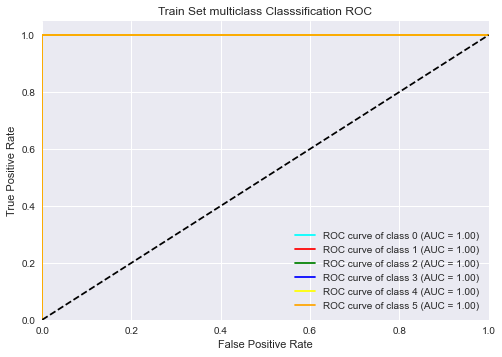


Test Acuracy: 0.842105
Test Error: 0.157895
Confusion Matrix on Test Dataset:
[[3 1 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


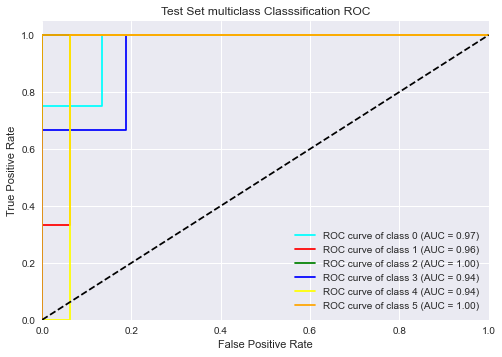

In [34]:
k=max_l

print("Best L value: "+str(k))

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]

model = LogisticRegressionCV(cv=5, penalty= "l1",solver="saga",random_state=17)
model.fit(x1,y1)
prediction = model.predict(x1)
c_matrix = metrics.confusion_matrix(y1, prediction)
print("Train Acuracy: %f"%model.score(x1,y1))
print("Confusion Matrix on Train Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(y1)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(x1)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train Set multiclass Classsification ROC")
plt.legend(loc="lower right")
plt.show()


print()
xTest = test_binary.loc[:, test_binary.columns!='Activity']
yTest = test_binary["Activity"]

prediction = model.predict(xTest)
c_matrix = metrics.confusion_matrix(yTest, prediction)
print("Test Acuracy: %f"%model.score(xTest,yTest))
print("Test Error: %f"%(1-model.score(xTest,yTest)))
print("Confusion Matrix on Test Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(yTest)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(xTest)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set multiclass Classsification ROC")
plt.legend(loc="lower right")
plt.show()

**The Test Error for multinomial classification with L1 penalised and saga as solver is 0.15**

# Naive Bayes Classifier

## Using Gaussian NB

In [35]:
from sklearn.naive_bayes import GaussianNB

In [36]:
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
    
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 
        
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    model = GaussianNB()
    model.fit(x1,y1)

    print("Accuracy: %f"%model.score(x1,y1))
    if max_val_acc<model.score(x1,y1):
        max_val_acc= model.score(x1,y1)
        max_l = k
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l)

L value: 1
Accuracy: 0.913043

L value: 2
Accuracy: 0.956522

L value: 3
Accuracy: 0.956522

L value: 4
Accuracy: 0.956522

L value: 5
Accuracy: 0.942029

L value: 6
Accuracy: 0.971014

L value: 7
Accuracy: 0.971014

L value: 8
Accuracy: 0.942029

L value: 9
Accuracy: 0.971014

L value: 10
Accuracy: 0.956522

L value: 11
Accuracy: 0.956522

L value: 12
Accuracy: 0.985507

L value: 13
Accuracy: 0.971014

L value: 14
Accuracy: 0.971014

L value: 15
Accuracy: 0.985507

L value: 16
Accuracy: 0.985507

L value: 17
Accuracy: 0.985507

L value: 18
Accuracy: 0.956522

L value: 19
Accuracy: 0.985507

L value: 20
Accuracy: 0.971014

0.9855072463768116 12


**The best value of l is 12**<br>
Re-fitting the model below with the best value of l and calculating the train and test errors

Best L value: 12
Train Acuracy: 0.985507
Confusion Matrix on Train Dataset:
[[ 8  0  1  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 0  0  0 12  0  0]
 [ 0  0  0  0 12  0]
 [ 0  0  0  0  0 12]]


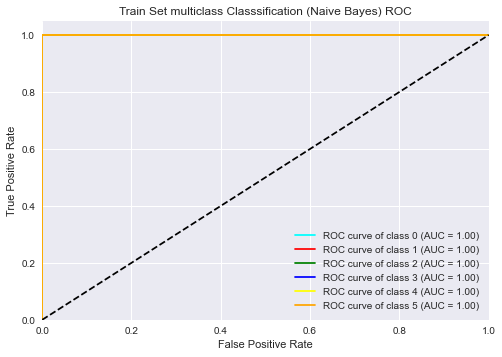


Test Acuracy: 0.842105
Test Error: 0.157895
Confusion Matrix on Train Dataset:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 2 1 0]
 [0 0 0 0 0 3]]


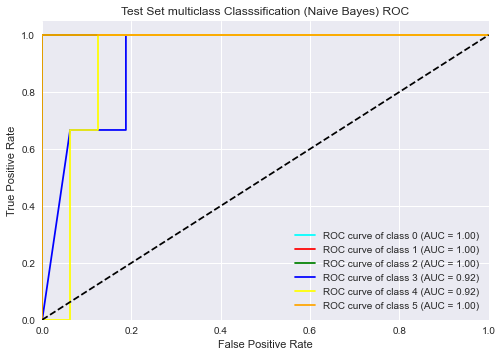

In [37]:
k=max_l

print("Best L value: "+str(k))

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]

model = GaussianNB()
model.fit(x1,y1)
prediction = model.predict(x1)
c_matrix = metrics.confusion_matrix(y1, prediction)
print("Train Acuracy: %f"%model.score(x1,y1))
print("Confusion Matrix on Train Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(y1)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(x1)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train Set multiclass Classsification (Naive Bayes) ROC")
plt.legend(loc="lower right")
plt.show()


print()
xTest = test_binary.loc[:, test_binary.columns!='Activity']
yTest = test_binary["Activity"]

prediction = model.predict(xTest)
c_matrix = metrics.confusion_matrix(yTest, prediction)
print("Test Acuracy: %f"%model.score(xTest,yTest))
print("Test Error: %f"%(1-model.score(xTest,yTest)))
print("Confusion Matrix on Train Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(yTest)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(xTest)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set multiclass Classsification (Naive Bayes) ROC")
plt.legend(loc="lower right")
plt.show()

## Using Multinomial priors

In [38]:
from sklearn.naive_bayes import MultinomialNB

In [39]:
l_vals = [i for i in range(1,21)]
feature_dict = {}
max_val_acc = 0
for k in l_vals:
    print("L value: "+str(k))
    
    features_new = create_features([1,2,3,4,5,6],folder,series,k)
    
    train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 
        
    x1 = train_binary.loc[:, train_binary.columns!='Activity']
    y1 = train_binary["Activity"]
    model = MultinomialNB()
    model.fit(x1,y1)

    print("Accuracy: %f"%model.score(x1,y1))
    if max_val_acc<model.score(x1,y1):
        max_val_acc= model.score(x1,y1)
        max_l = k
    
    print()
    print("===================================================================================================")
print(max_val_acc,max_l)

L value: 1
Accuracy: 0.898551

L value: 2
Accuracy: 0.927536

L value: 3
Accuracy: 0.942029

L value: 4
Accuracy: 0.927536

L value: 5
Accuracy: 0.942029

L value: 6
Accuracy: 0.927536

L value: 7
Accuracy: 0.942029

L value: 8
Accuracy: 0.942029

L value: 9
Accuracy: 0.942029

L value: 10
Accuracy: 0.927536

L value: 11
Accuracy: 0.927536

L value: 12
Accuracy: 0.942029

L value: 13
Accuracy: 0.942029

L value: 14
Accuracy: 0.942029

L value: 15
Accuracy: 0.942029

L value: 16
Accuracy: 0.942029

L value: 17
Accuracy: 0.942029

L value: 18
Accuracy: 0.942029

L value: 19
Accuracy: 0.942029

L value: 20
Accuracy: 0.942029

0.9420289855072463 3


L value: 3
Train Acuracy: 0.942029
Confusion Matrix on Train Dataset:
[[ 9  0  0  0  0  0]
 [ 0 12  0  0  0  0]
 [ 0  0 12  0  0  0]
 [ 1  0  1  9  1  0]
 [ 0  0  0  1 11  0]
 [ 0  0  0  0  0 12]]


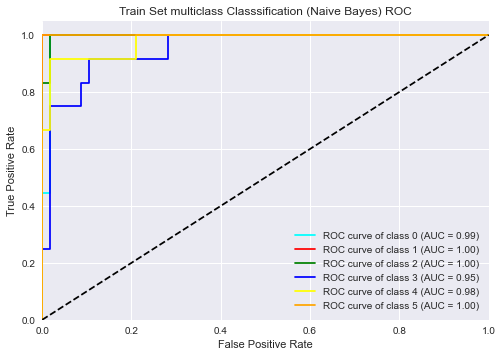


Test Acuracy: 0.894737
Test Error: 0.105263
Confusion Matrix on Train Dataset:
[[4 0 0 0 0 0]
 [0 3 0 0 0 0]
 [0 0 3 0 0 0]
 [0 0 0 2 1 0]
 [0 0 0 1 2 0]
 [0 0 0 0 0 3]]


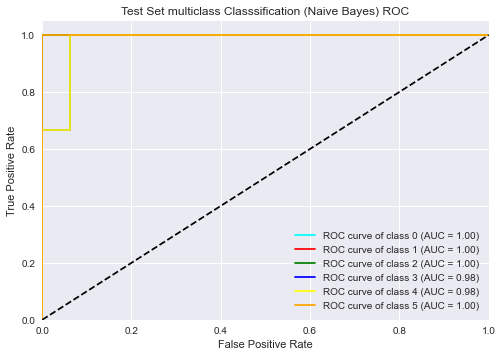

In [40]:
k=max_l

print("L value: "+str(k))

features_new = create_features([1,2,3,4,5,6],folder,series,k)
  
train_binary,test_binary = getTrainTestSplit_from_featuresNew(features_new,"type2") 

x1 = train_binary.loc[:, train_binary.columns!='Activity']
y1 = train_binary["Activity"]

model = MultinomialNB()
model.fit(x1,y1)
prediction = model.predict(x1)
c_matrix = metrics.confusion_matrix(y1, prediction)
print("Train Acuracy: %f"%model.score(x1,y1))
print("Confusion Matrix on Train Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(y1)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(x1)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Train Set multiclass Classsification (Naive Bayes) ROC")
plt.legend(loc="lower right")
plt.show()


print()
xTest = test_binary.loc[:, test_binary.columns!='Activity']
yTest = test_binary["Activity"]

prediction = model.predict(xTest)
c_matrix = metrics.confusion_matrix(yTest, prediction)
print("Test Acuracy: %f"%model.score(xTest,yTest))
print("Test Error: %f"%(1-model.score(xTest,yTest)))
print("Confusion Matrix on Train Dataset:")
print(c_matrix)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
one_hot = pd.get_dummies(yTest)
# print(one_hot[0])
for i in range(6):
    prediction_prob = model.predict_proba(xTest)
    fpr[i], tpr[i], _ = metrics.roc_curve(one_hot[i], prediction_prob[:, i])
    roc_auc[i] = metrics.auc(fpr[i], tpr[i])

plt.figure()
colors = ["cyan","red","green","blue","yellow","orange"]
for i, color in zip(range(6), colors):
    plt.plot(
        fpr[i],
        tpr[i],
        color=color,
        label="ROC curve of class {0} (AUC = {1:0.2f})".format(i, roc_auc[i]),
    )

plt.plot([0, 1], [0, 1], "k--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Test Set multiclass Classsification (Naive Bayes) ROC")
plt.legend(loc="lower right")
plt.show()

**Inference:**
Out of Naive Bayes with Gaussian prior and Multinomial Prior, the one with multinomial prior performs better on the test set giving us an accuracy of 89.47%

- Accuracies on test set are:
    - Multinomial Regression Model:
        - With Liblinear as Solver = 73.68%
        - With Saga as Solver = 84.2%
    - Naive Bayes with Gaussian priors = 84.21%
    - Naive Bayes with Multinomial priors = 89.47%
- Hence, **Naive Bayes with Multinomial priors** is the best for multi-class classification for this sample of dataset as it has the **highest accuracy 89.47%.**


# References
- https://machinelearningmastery.com/smote-oversampling-for-imbalanced-classification/
- https://seaborn.pydata.org/generated/seaborn.pairplot.html
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html#
- https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html
- https://scikit-learn.org/stable/auto_examples/feature_selection/plot_rfe_with_cross_validation.html#sphx-glr-auto-examples-feature-selection-plot-rfe-with-cross-validation-py
- https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegressionCV.html
- https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html